In [49]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from aero_design_functions import get_design_functions, single_point_design
from scipy.optimize import fsolve
from lacbox.io import load_pwr, load_ind, load_inds, load_ae, load_pc
from lacbox.test import test_data_path
from myteampack import MyHTC
from pathlib import Path
from our_functions import extract_bd_master
from our_values import *

plt.rcParams.update({'font.family': 'serif', 'font.size':14})


## COMPUTE REMODEL PARAMETERS <b>
modifications: <b>
- shorter blade: -1% <b>
- larger chord: +0.5%

In [50]:
# compute R_Y and V_RATED_Y

#Former class IA
V_rated_X = 11.4  # m/s
I_rated_X = 0.16
R_X = 89.17  # m

#New Class IIIB
I_rated_Y = 0.14

# Define the system of nonlinear equations
def equations(vars):
    V_rated_Y, R_Y = vars
    eq1 = V_rated_Y - (R_X / R_Y)**(2/3) * V_rated_X
    eq2 = R_Y - ((V_rated_X * (1 + 2 * I_rated_X)) / (V_rated_Y * (1 + 2 * I_rated_Y)))**(2/3) * R_X
    return [eq1, eq2]

# Initial guesses for V_rated_Y and R_Y
initial_guess = [1, 1]

# Solve the system of equations
solution = fsolve(equations, initial_guess)

# Extract the solution
V_rated_Y, R_Y = solution

print(f'type      |    R     |    V      ')
print(f'DTU 10 MW |  {R_X:.3f}  |  {V_rated_X:.3f}')
print(f'Group1    |  {R_Y:.3f}  |  {V_rated_Y:.3f}')


# modification: new blade is 1% smaller to reduce loads
R_Y = R_Y *0.99
V_rated_Y = (R_X/R_Y)**(2/3)*V_rated_X

print(f'remodel   |  {R_Y:.3f}  |  {V_rated_Y:.3f}')

print()
print('final values')
print(f"V_rated_Y: {V_rated_Y} m/s")
print(f"R_Y: {R_Y} m")
#

type      |    R     |    V      
DTU 10 MW |  89.170  |  11.400
Group1    |  92.524  |  11.123
remodel   |  91.599  |  11.198

final values
V_rated_Y: 11.197563974599802 m/s
R_Y: 91.59899634459074 m


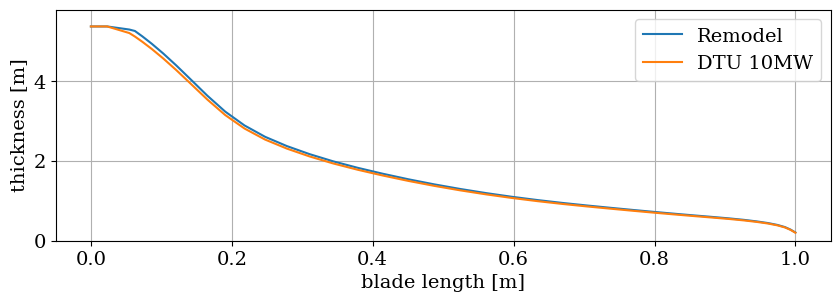

In [51]:
# new thickness

Data_ae = load_ae("dtu_10mw/data/DTU_10MW_RWT_ae.dat")

# Data from the DTU 10MW
data_ae = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }

abs_t_dtu = data_ae["chord"]*data_ae["rel_th"]/100 # dtu thickness
abs_t=data_ae["chord"]*data_ae["rel_th"]/100*R_Y/R_X # new thickness

# to force the thickness at the root and make it smoother
abs_t[0:2]=data_ae["chord"][0:2]
abs_t[2]=0.99*abs_t[2]

#plot the former blade shape and the new one
plt.figure(figsize=(10,3))
plt.plot(data_ae['curve']/max(data_ae['curve']), abs_t, label='Remodel')
plt.plot(data_ae['curve']/max(data_ae['curve']), abs_t_dtu, label='DTU 10MW')
plt.ylim(0,5.8)
plt.xlabel('blade length [m]')
plt.ylabel('thickness [m]')
plt.grid()
plt.legend()
plt.savefig('plots/bd_thickness_blade_span.pdf', format='pdf')
plt.show()

zoom = False
if zoom:
    plt.figure(figsize=(10,3))
    plt.plot(data_ae['curve'], abs_t,     marker='o', label='Remodel')
    plt.plot(data_ae['curve'], abs_t_dtu, marker='o', label='DTU 10MW')
    plt.xlabel('blade length [m]')
    plt.ylabel('thickness [m]')
    plt.grid()
    plt.legend()
    plt.xlim(0,10)
    plt.ylim(4, 6)
    plt.show()


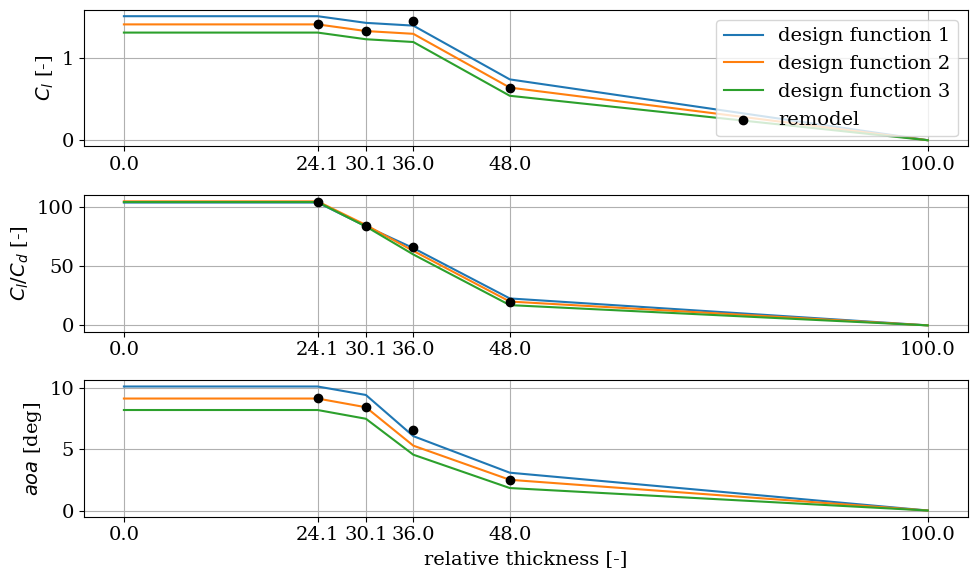

In [52]:
# design function

# Define a cl plot for the 10MW using the pc.dat
Data_cl = load_pc("dtu_10mw/data/DTU_10MW_RWT_pc.dat") # return a list per blade
n = len(Data_cl)-2 # exclude airfoils of 100% and 60% relative thickness
des_param = np.zeros((4,n)) # relative thickness, cl design, cd design, AoA design
arg_0 = [63,63,63,58] # indices of the AoAs before stall

for k in range(n):
    cl_max = np.amax(Data_cl[k]["cl"][50:arg_0[k]])  # Maximum lift coefficient within the range
    cl_des = cl_max - 0.4

    # Finding corresponding AoA
    arg_max = np.where(Data_cl[k]["cl"] == cl_max)
    aoa_max = Data_cl[k]["aoa_deg"][arg_max]
    
    # Interpolating to find AoA and Cd of Cl design
    aoa_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["aoa_deg"][50:arg_0[k]])
    cd_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["cd"][50:arg_0[k]])
    des_param[:, k] = [Data_cl[k]["tc"], cl_des, cd_des, aoa_des]

_, _, _, tc_vals, cl_vals1, cd_vals1, aoa_vals1 = get_design_functions(1)
_, _, _, tc_vals, cl_vals2, cd_vals2, aoa_vals2 = get_design_functions(2)
_, _, _, tc_vals, cl_vals3, cd_vals3, aoa_vals3 = get_design_functions(3)


fig1, axs1 = plt.subplots(3, 1, num=1, figsize=(10,6), clear=True) 
# lift
axs1[0].plot(tc_vals, cl_vals1, label='design function 1')
axs1[0].plot(tc_vals, cl_vals2, label='design function 2')
axs1[0].plot(tc_vals, cl_vals3, label='design function 3')
axs1[0].scatter(des_param[0], des_param[1], label='remodel', color='k',zorder=3)
axs1[0].set_ylabel('$C_l$ [-]')
axs1[0].legend()
axs1[0].grid()

# lift / drag
axs1[1].plot(tc_vals, cl_vals1/cd_vals1)
axs1[1].plot(tc_vals, cl_vals2/cd_vals2)
axs1[1].plot(tc_vals, cl_vals3/cd_vals3)
axs1[1].scatter(des_param[0], des_param[1]/des_param[2], color='k', zorder=3)
axs1[1].set_ylabel('$C_l/C_d$ [-]')
axs1[1].grid()

# AoA
axs1[2].plot(tc_vals, aoa_vals1)
axs1[2].plot(tc_vals, aoa_vals2)
axs1[2].plot(tc_vals, aoa_vals3)
axs1[2].scatter(des_param[0], des_param[3], color='k', zorder=3)
axs1[2].set_ylabel('$aoa$ [deg]')
axs1[2].set_xlabel('relative thickness [-]')
axs1[2].grid()

axs1[2].set_xticks(tc_vals)  # for the bottom plot
plt.setp(axs1, xticks=tc_vals)  # apply xticks for all subplots

plt.tight_layout()
plt.savefig('plots/bd_computed_vs_design funct.pdf', format='pdf')
plt.show()



In [53]:
# evaluate optimal blade hape with single_point_design function
# change in max chord

r_hub = 2.8  # Hub radius [m]
r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]
chord_root = 5.38  # Chord size at the root [m]
chord_max_redesign = 6.3 
chord_max = chord_max_redesign*1.01 # max chord increased by 1% to increase power production


t = abs_t # Absolute thickness [m]
B = 3  # Number of blades [#]
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)

TSR = np.linspace(6,12,20)
CP_list = []
for tsr in TSR:
    # %% Solving for the a single design
    chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
        r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
    CP_list.append(CP)

CP_max=np.amax(CP_list)
TSR_max=TSR[np.argmax(CP_list)]


print('best blade:')
print('CP =', CP_max)
print('TSR =', TSR_max)



best blade:
CP = 0.44352485763123617
TSR = 7.2631578947368425


## CREATE NEW MASTER FILE

Data saved to remodel/_master/modify.txt
Data saved to remodel/data/remodel_ae.dat


C:\Users\nicol\AppData\Local\Temp\ipykernel_15164\1127801027.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


27


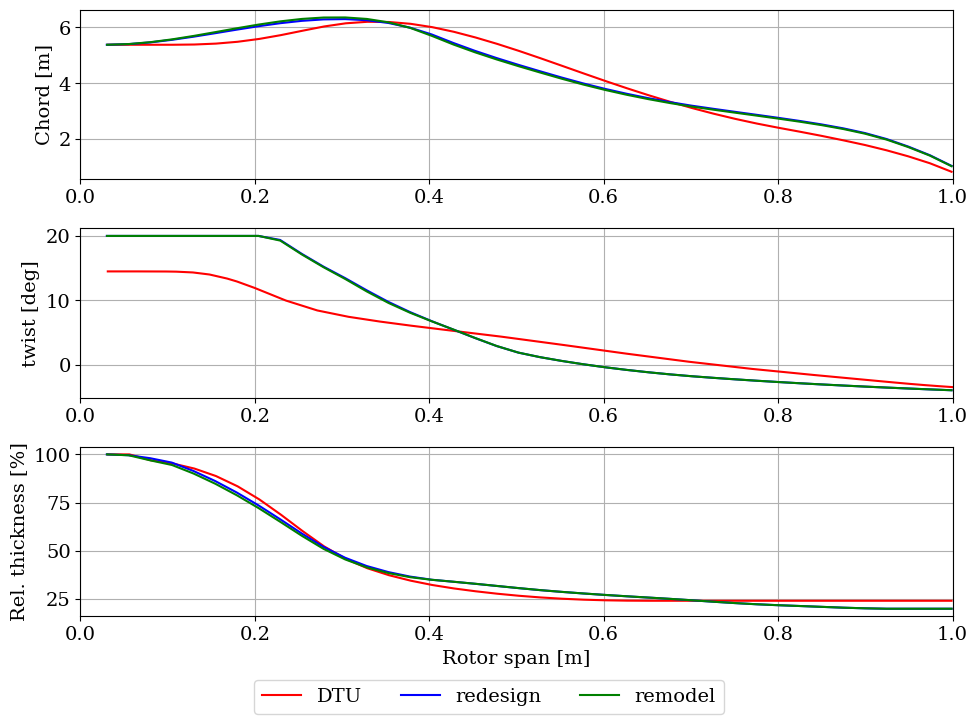

In [54]:
# new z and twist

r_hub = 2.8  # Hub radius [m]
r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]
scale = (R_Y - r_hub)/(R_X - r_hub)
tsr = 7.2631578947368425

cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)


file_path = "dtu_10mw/_master/dtu_10mw.htc"
data_master = extract_bd_master(file_path)

new_z =data_master['z']*scale
new_twist = -np.interp(new_z, r, twist)             # minus sign to be consistent with htc

twist_interp = False
if twist_interp == True:
    plt.figure(figsize=(12,4))
    plt.plot(data_master['z'], data_master['twist'], marker='o', label='DTU', color='r')
    plt.plot(new_z, new_twist, marker='o',  label='remodel', color='g')
    plt.xlabel('blade span [m]')
    plt.ylabel('twist [deg]')
    plt.grid()
    plt.legend()
    plt.show()


# write down changes

# blade definition in master file
output_file = 'remodel/_master/modify.txt'

# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'# change new_htc_structure_blade1 with this\n\n')
    for i in range(len(data_master['number'])):
        # Construct the formatted string
        line = f"sec {data_master['number'][i]} {data_master['x'][i]:.5E} {data_master['y'][i]:.5E} {new_z[i]:.5E} {new_twist[i]:.5E} ;\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")


# aerodynamic definition
new_curve = r - r_hub

output_file = 'remodel/data/remodel_ae.dat'

# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'1\n')
    file.write(f'1  40\n')
    for i in range(40):
        # Construct the formatted string
        line = f"{new_curve[i]:.5E} {chord[i]:.5E} {tc[i]:.5E} 1  ;\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")



# display aerodynamic data
Data_ae = load_ae("dtu_10mw/data/DTU_10MW_RWT_ae.dat")
ae_DTU = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }
r_DTU = np.linspace(r_hub, R_X - 0.1, 40)

Data_ae = load_ae("our_design/data/DTU_10MW_RWT_ae.dat")
ae_our = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }
r_our = np.linspace(r_hub, R_Y_old - 0.1, 40)
twist_our = [20.        , 20.        , 20.        , 20.        , 20.        , 20.        ,
             20.        , 20.        , 19.37724617, 17.22497201, 15.24863829, 13.46830149,
             11.57024301,  9.7753592 ,  8.19674475,  6.78824525,  5.48401412,  4.17750717,
             2.93210526 ,  1.91483855,  1.21180261,  0.62783694,  0.10892417, -0.35287007,
             -0.76408582, -1.12993299, -1.45656244, -1.74364384, -1.99196778, -2.22283601,
             -2.43943218, -2.64302576, -2.83474162, -3.01557979, -3.18643217, -3.34809659,
             -3.50128882, -3.64665274, -3.78476909, -3.91616297]



fig2, axs2 = plt.subplots(3, 1, num=1, figsize=(10,7), clear=True)
# Chord
axs2[0].plot(r_DTU/R_X,     ae_DTU['chord'], color='r', label="DTU")
axs2[0].plot(r_our/R_Y_old, ae_our['chord'], color='b', label="redesign")
axs2[0].plot(r/R_Y, chord, color='g', label="remodel")
axs2[0].set_ylabel("Chord [m]")
axs2[0].set_xlim(0, 1)
axs2[0].grid(True)

# Twist
axs2[1].plot((data_master['z']+R_HUB)/R_X, - data_master['twist'], color='r')
axs2[1].plot(r_our/R_Y_old, twist_our, color='b')
axs2[1].plot(r/R_Y, twist, color='g')
axs2[1].set_ylabel("twist [deg]")
axs2[1].set_xlim(0, 1)
axs2[1].grid(True)

# t/c
axs2[2].plot(r_DTU/R_X,     ae_DTU['rel_th'], color='r')
axs2[2].plot(r_our/R_Y_old, ae_our['rel_th'], color='b')
axs2[2].plot(r/R_Y, tc, color='g')
axs2[2].set_ylabel("Rel. thickness [%]")
axs2[2].set_xlim(0, 1)
axs2[2].grid(True)
axs2[2].set_xlabel("Rotor span [m]")

fig2.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
fig2.tight_layout()
#fig2.savefig('plots/bd_CP_vs_TSR.pdf', format='pdf')
fig2.show()

print(len(data_master['twist']))




In [55]:
# compute omega

omega_max_DTU = 9.60
omega_max_formula = TSR_max * V_rated_Y / R_Y * 60 / (2*np.pi)

tipSpeedMax = 90
omega_max_TS = tipSpeedMax/R_Y * 60 / (2*np.pi)

print('omega DTU            ', omega_max_DTU)
print('omega from TSR max   ', omega_max_formula)
print('omega from tip speed', omega_max_TS)

omega DTU             9.6
omega from TSR max    8.478708506949244
omega from tip speed 9.382599449704426


## RUN SIMULATIONS

In [56]:
# multitsr input file

# remodel
TSR_range = np.arange(5.5,10.5,0.2)
V_rated_Y_range = np.arange(V_rated_Y, V_rated_Y + len(TSR_range) * 0.001 - 0.001, 0.001)
omega_range = TSR_range * V_rated_Y_range / R_Y * 60 / (2*np.pi)

output_file = 'remodel/data/remodel_multitsr.opt'
# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'{int(len(TSR_range))} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    for i in range(len(TSR_range)):
        # Construct the formatted string
        line = f"          {V_rated_Y_range[i]:6.6f}          0.000000          {omega_range[i]:6.6f}          500.000000          1000.000000\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")


# for DTU 10 MW
V_rated_X_range = np.arange(V_rated_X, V_rated_X + len(TSR_range) * 0.001 - 0.001, 0.001)
omega_range_X = TSR_range * V_rated_X_range/ R_X * 60 / (2*np.pi)
output_file = 'dtu_10mw/data/dtu_10mw_multitsr.opt'

# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'{int(len(TSR_range))} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    for i in range(len(TSR_range)):
        # Construct the formatted string
        line = f"          {V_rated_Y_range[i]:6.6f}          0.000000          {omega_range[i]:6.6f}          500.000000          1000.000000\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")



Data saved to remodel/data/remodel_multitsr.opt
Data saved to dtu_10mw/data/dtu_10mw_multitsr.opt


## POST PROCESS

DTU: max CP = 0.483 at TSR = 8.300
redesign: max CP = 0.457 at TSR = 7.500
redesign: max CP = 0.459 at TSR = 7.700
anal: max CP = 0.444 at TSR = 7.100

TSR_OPT =  7.700000000000002
CP_MAX =  0.4593129255


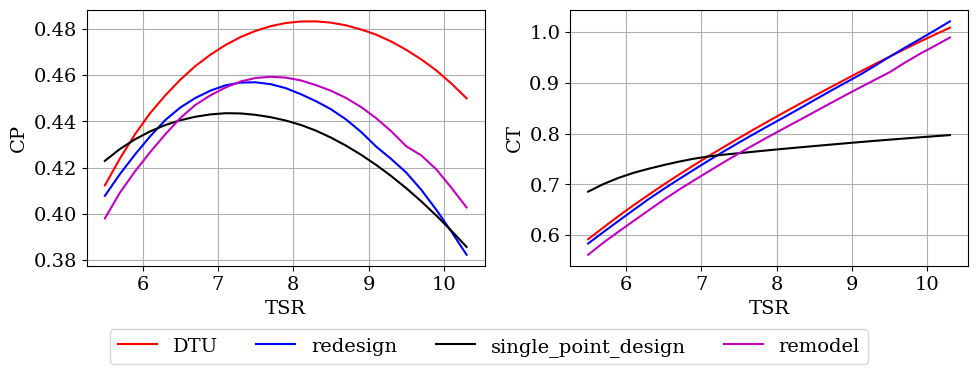

In [87]:
# Side-by-side plots of the power and thrust coefficients calculated with HAWC2S at design pitch versus TSR

pwr_data = load_pwr("remodel/res_hawc2s/remodel_hawc2s_multitsr.pwr")
pwr_data_DTU_10_MW = load_pwr("dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_multitsr.pwr")
pwr_data_redesign = load_pwr("our_design/res_hawc2s/Group1_redesign_hawc2s_multiwsp.pwr")

CP_list = []
CT_list = []
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)

for tsr in TSR_range:
    # %% Solving for the a single design
    chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
        r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
    CP_list.append(CP)
    CT_list.append(CT)

CP_array = np.array(CP_list)
CT_array = np.array(CT_list)


# find max
CP_max_DTU = np.amax(pwr_data_DTU_10_MW["Cp"])
TSR_max_DTU = TSR_range[np.argmax(pwr_data_DTU_10_MW["Cp"])]
CP_max_redesign = np.amax(pwr_data_redesign["Cp"])
TSR_max_redesign = TSR_range[np.argmax(pwr_data_redesign["Cp"])]
CP_max_remodel = np.amax(pwr_data["Cp"])
TSR_max_remodel = TSR_range[np.argmax(pwr_data["Cp"])]
CP_max_anal = np.amax(CP_array)
TSR_max_anal = TSR_range[np.argmax(CP_array)]


print(f'DTU: max CP = {CP_max_DTU:.3f} at TSR = {TSR_max_DTU:.3f}')
print(f'redesign: max CP = {CP_max_redesign:.3f} at TSR = {TSR_max_redesign:.3f}')
print(f'redesign: max CP = {CP_max_remodel:.3f} at TSR = {TSR_max_remodel:.3f}')
#print(f'redesign percentual difference with computed: max CP = , max TSR = {(TSR_max_redesign - TSR_opt)/TSR_opt*100:.3f}%')
print(f'anal: max CP = {CP_max_anal:.3f} at TSR = {TSR_max_anal:.3f}')


print()
print('TSR_OPT = ', TSR_max_remodel)
print('CP_MAX = ', CP_max_remodel)

fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,3.5), clear=True)
axs1[0].plot(TSR_range, pwr_data_DTU_10_MW["Cp"], color='r')
axs1[0].plot(TSR_range, pwr_data_redesign["Cp"], color='b')
axs1[0].plot(TSR_range, CP_array, color='k')
axs1[0].plot(TSR_range, pwr_data["Cp"], color='m')
axs1[0].set_xlabel("TSR")
axs1[0].set_ylabel("CP")
axs1[0].grid(True)
#axs1[0].set_xlim(min(TSR_range), max(TSR_range))


axs1[1].plot(TSR_range, pwr_data_DTU_10_MW["Ct"], color='r', label='DTU')
axs1[1].plot(TSR_range, pwr_data_redesign["Ct"], color='b', label='redesign')
axs1[1].plot(TSR_range, CT_array, color='k', label='single_point_design')
axs1[1].plot(TSR_range, pwr_data["Ct"], color='m', label='remodel')
axs1[1].set_xlabel("TSR")
axs1[1].set_ylabel("CT")
#axs1[1].legend()
axs1[1].grid(True)
#axs1[1].set_xlim(min(TSR_range), max(TSR_range))

# Adjust layout and show the figure
fig1.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.savefig('plots/bd_CP_vs_TSR.pdf', format='pdf')
plt.show()


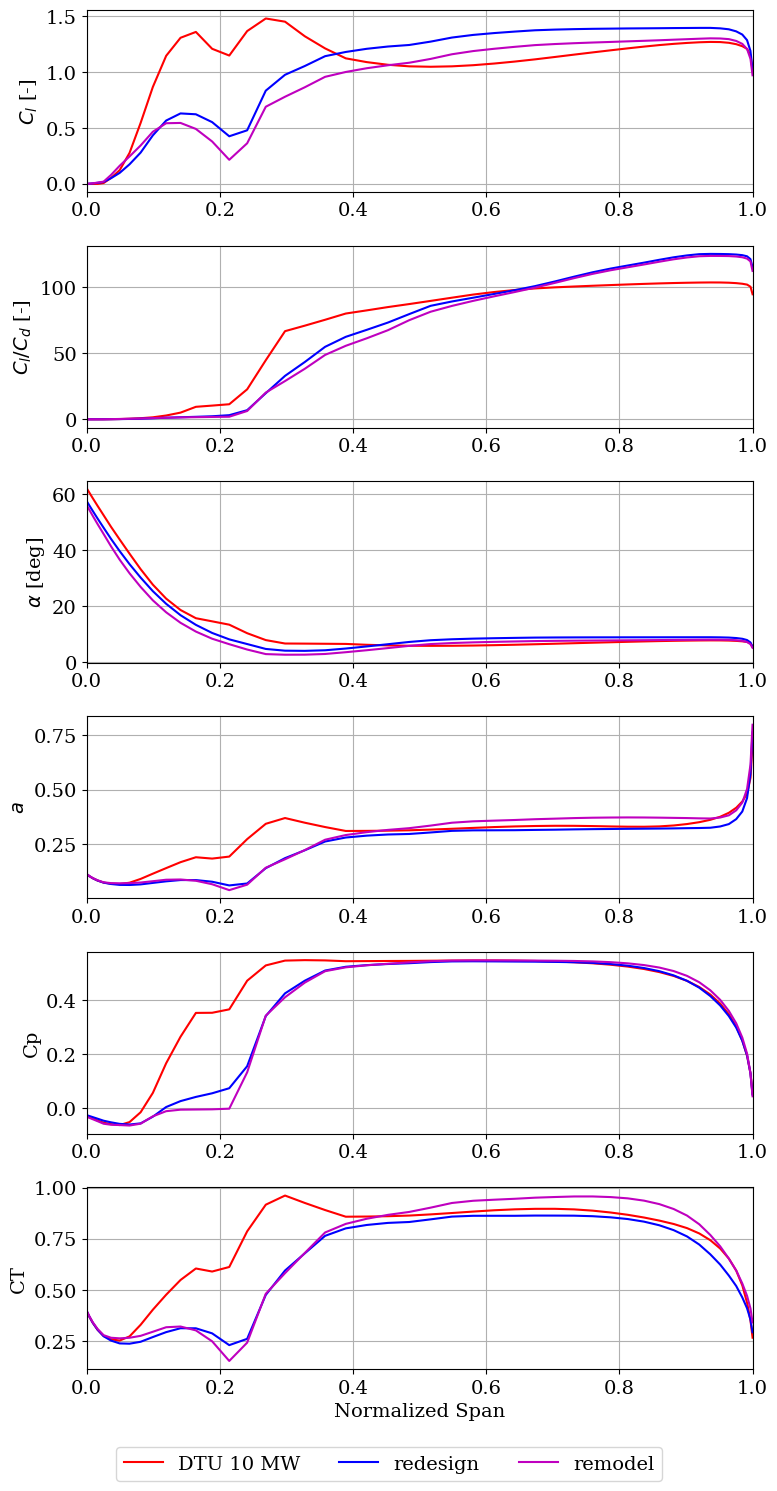

In [89]:
# open induction files

ind_rem = load_ind('remodel/res_hawc2s/remodel_hawc2s_1wsp_u11198.ind')
ind_DTU = load_ind('dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind')
ind_our = load_ind('our_design/res_hawc2s/Group1_redesign_hawc2s_1wsp_u11123.ind')
R_Y_old = 92.52423873190985


# Create subplots with increased vertical spacing
fig1, axs1 = plt.subplots(6, 1, num=1, clear=True, figsize=(8, 15))  # Adjust figure size for better spacing
fig1.subplots_adjust(hspace=0.4)  # Increase the space between the plots

# Plot Cl
axs1[0].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["Cl"], color='r', label='DTU 10 MW')
axs1[0].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["Cl"], color='b', label='redesign')
axs1[0].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["Cl"], color='m', label='remodel')
axs1[0].set_ylabel("$C_l$ [-]")
axs1[0].set_xlim(0, 1)
axs1[0].grid(True)  # Add grid

# Plot Cl / Cd
axs1[1].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["Cl"]/ind_DTU["Cd"], color='r')
axs1[1].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["Cl"]/ind_our["Cd"], color='b')
axs1[1].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["Cl"]/ind_rem["Cd"], color='m')
axs1[1].set_ylabel("$C_l / C_d$ [-]")
axs1[1].set_xlim(0, 1)
axs1[1].grid(True)  # Add grid

# Plot AoA with label
axs1[2].plot(ind_DTU["s_m"]/(R_X-r_hub),     np.rad2deg(ind_DTU["aoa_rad"]), color='r')
axs1[2].plot(ind_our["s_m"]/(R_Y_old-r_hub), np.rad2deg(ind_our["aoa_rad"]), color='b')
axs1[2].plot(ind_rem["s_m"]/(R_Y-r_hub),     np.rad2deg(ind_rem["aoa_rad"]), color='m')
axs1[2].set_ylabel(r"$\alpha$ [deg]")
axs1[2].set_xlim(0, 1)
axs1[2].grid(True)  # Add grid


axs1[3].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["a"], color='r')
axs1[3].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["a"], color='b')
axs1[3].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["a"], color='m')
axs1[3].set_ylabel(r"$a$")
axs1[3].set_xlim(0, 1)
axs1[3].grid(True)  # Add grid

axs1[4].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["CP"], color='r')
axs1[4].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["CP"], color='b')
axs1[4].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["CP"], color='m')
axs1[4].set_ylabel('Cp')
axs1[4].set_xlim(0, 1)
axs1[4].grid(True)  # Add grid

axs1[5].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["CT"], color='r')
axs1[5].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["CT"], color='b')
axs1[5].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["CT"], color='m')
axs1[5].set_ylabel('CT')
axs1[5].set_xlabel("Normalized Span")  # Add label for the last plot
axs1[5].set_xlim(0, 1)
axs1[5].grid(True)  # Add grid

plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.001))
plt.subplots_adjust(bottom=0.08)  # Add more space at the bottom if needed
#plt.savefig('03_part2_quantities_vs_radius.pdf', format='pdf')
plt.show()



C:\Users\nicol\AppData\Local\Temp\ipykernel_15164\3658054296.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


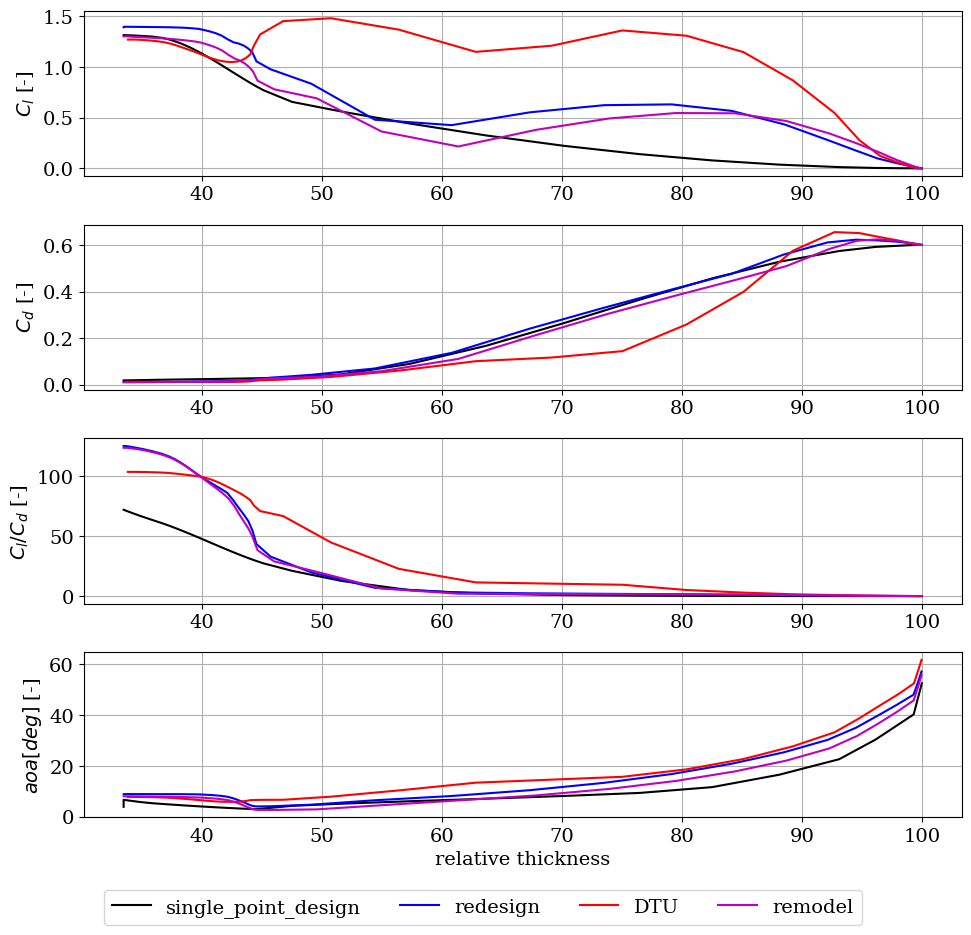

In [90]:
# parameters over tc and over span

ind_rem = load_ind('remodel/res_hawc2s/remodel_hawc2s_1wsp_u11198.ind')
ind_DTU = load_ind('dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind')
ind_our = load_ind('our_design/res_hawc2s/Group1_redesign_hawc2s_1wsp_u11123.ind')
R_Y_old = 92.52423873190985



r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
r_analytical = r - r_hub

# print(ind_rem.keys())
# dict_keys(['s_m', 'a', 'ap', 'flow_angle_rad', 'aoa_rad', 'flow_speed_ms', 'Fx_Nm', 'Fy_Nm', 'M_Nmm', 'UX0_m', 'UY0_m', 'UZ0_m', 'twist_rad', 'X_AC0_m', 'Y_AC0_m', 'Z_AC0_m', 'Cl', 'Cd', 'Cm', 'CLp0_rad', 'CDp0_rad', 'CMp0_rad', 'F0', 'F_rad', 'CL_FS0', 'CLFS_rad', 'V_a_ms', 'V_t_ms', 'torsion_rad', 'vx_ms', 'vy_ms', 'chord_m', 'CT', 'CP', 'angle_rad', 'v_1', 'v_2', 'v_3'])

Data_ae = load_ae("dtu_10mw/data/DTU_10MW_RWT_ae.dat")
ae_DTU = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }
r_DTU = np.linspace(r_hub, R_X - 0.1, 40)

Data_ae = load_ae("our_design/data/DTU_10MW_RWT_ae.dat")
ae_our = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }
r_our = np.linspace(r_hub, R_Y_old - 0.1, 40)



tc_interp_rem = np.interp(ind_rem['s_m'], r_analytical, tc)
tc_interp_DTU = np.interp(ind_DTU['s_m'], r_analytical, tc)
tc_interp_our = np.interp(ind_our['s_m'], r_analytical, tc)


fig1, axs1 = plt.subplots(4, 1, num=1, figsize=(10,9), clear=True) 
axs1[0].plot(tc, cl, color='k', label='single_point_design')
axs1[0].plot(tc_interp_our[:-6], ind_our['Cl'][:-6], color='b', label='redesign')
axs1[0].plot(tc_interp_DTU[:-6], ind_DTU['Cl'][:-6], color='r', label='DTU')
axs1[0].plot(tc_interp_rem[:-6], ind_rem['Cl'][:-6], color='m', label='remodel')
axs1[0].set_ylabel("$C_l$ [-]")
axs1[0].grid(True) 

axs1[1].plot(tc, cd, color='k')
axs1[1].plot(tc_interp_our[:-6], ind_our['Cd'][:-6], color='b')
axs1[1].plot(tc_interp_DTU[:-6], ind_DTU['Cd'][:-6], color='r')
axs1[1].plot(tc_interp_rem[:-6], ind_rem['Cd'][:-6], color='m')
axs1[1].set_ylabel("$C_d$ [-]")
axs1[1].grid(True) 

axs1[2].plot(tc, cl/cd, color='k')
axs1[2].plot(tc_interp_our[:-6], ind_our['Cl'][:-6]/ind_our['Cd'][:-6], color='b')
axs1[2].plot(tc_interp_DTU[:-6], ind_DTU['Cl'][:-6]/ind_DTU['Cd'][:-6], color='r')
axs1[2].plot(tc_interp_rem[:-6], ind_rem['Cl'][:-6]/ind_rem['Cd'][:-6], color='m')
axs1[2].set_ylabel("$C_l/C_d$ [-]")
axs1[2].grid(True) 


axs1[3].plot(tc, aoa, color='k')
axs1[3].plot(tc_interp_our[:-6], np.rad2deg(ind_our['aoa_rad'][:-6]), color='b')
axs1[3].plot(tc_interp_DTU[:-6], np.rad2deg(ind_DTU['aoa_rad'][:-6]), color='r')
axs1[3].plot(tc_interp_rem[:-6], np.rad2deg(ind_rem['aoa_rad'][:-6]), color='m')
axs1[3].set_ylabel("$aoa [deg]$ [-]")
axs1[3].grid(True) 
axs1[3].set_xlabel("relative thickness")

fig1.legend(loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
fig1.tight_layout()
fig1.savefig('plots/bd_function_tc.pdf', format='pdf')
fig1.show()

